In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import seaborn as sns

We begin by creating importing the raw data for each recipe, as well as a collection of interactions for each user

In [2]:
df_recipes = pd.read_csv("./fooddata/RAW_recipes-short.csv", usecols=['id', 'name'])[['id', 'name']]
df_recipes.rename(columns={'id': 'recipe_id'}, inplace=True)

In [3]:
# df_recipes.drop(df_recipes.tail(100000).index, inplace=True)
df_recipes.shape
df_recipes.head()

,recipe_id,name
0,137739,arriba baked winter squash mexican style
1,31490,a bit different breakfast pizza
2,112140,all in the kitchen chili
3,59389,alouette potatoes
4,44061,amish tomato ketchup for canning


In [4]:
df_users = pd.read_csv("./fooddata/RAW_interactions-short.csv", usecols=['user_id', 'recipe_id', 'rating'])
# df_users.drop(df_users.tail(500000).index, inplace=True)
df_users.shape
df_users.head()

,user_id,recipe_id,rating
0,38094,40893,4
1,1293707,40893,5
2,8937,44394,4
3,126440,85009,5
4,57222,85009,5


Next, we will combine these datasets and match each recipe the the rating given by the user

In [5]:
df_interactions = pd.merge(df_users, df_recipes, on='recipe_id')

In [6]:
df_interactions.head()

,user_id,recipe_id,rating,name
0,126440,85009,5,baked potato toppings
1,57222,85009,5,baked potato toppings
2,135017,254596,5,apple apricot pork chops crock pot
3,224088,254596,4,apple apricot pork chops crock pot
4,582223,254596,5,apple apricot pork chops crock pot


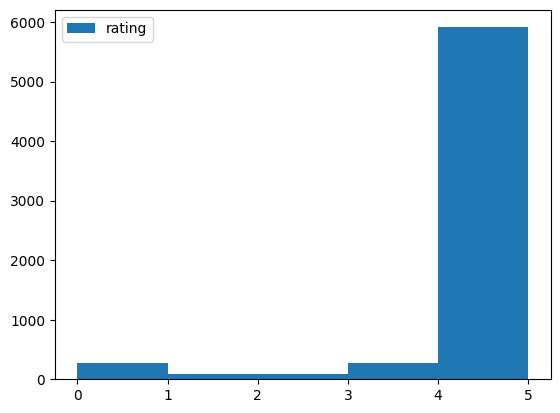

In [7]:
hist = df_interactions['rating'].hist(grid = False, bins = 5, legend = True)

c:\Users\Reginald\Documents\WGU\Capstone\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Reginald\Documents\WGU\Capstone\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Reginald\Documents\WGU\Capstone\venv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


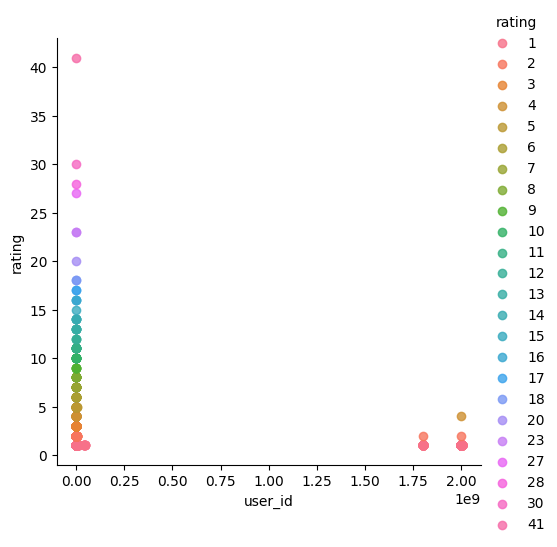

In [8]:
d1 = (df_interactions.groupby(by = ['user_id'])['rating']).count().reset_index()
d1.head()

sns.lmplot(x='user_id', y='rating', data=d1, fit_reg=False, hue='rating')

In [14]:
combined_rating = df_interactions.dropna(axis=0, subset=['name'])
rating_count = (combined_rating.groupby(by = ['name'])['rating']).count().reset_index()
rating_count.rename(columns={'rating': 'totalRatingCount'}, inplace=True)

In [15]:
rating_count.head()

,name,totalRatingCount
0,1 dish hot fudge swirl cake,2
1,1 minute no bake chocolatey cereal bites,1
2,10 min japanese simmered tofu hot pot,3
3,10 minute buffalo shrimp with blue cheese dip,17
4,100 chocolate cake,1


In [16]:
df_aggData = df_interactions.merge(rating_count, left_on='name', right_on='name', how='left')
df_aggData.head()

,user_id,recipe_id,rating,name,totalRatingCount
0,126440,85009,5,baked potato toppings,2
1,57222,85009,5,baked potato toppings,2
2,135017,254596,5,apple apricot pork chops crock pot,4
3,224088,254596,4,apple apricot pork chops crock pot,4
4,582223,254596,5,apple apricot pork chops crock pot,4


In [240]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(df_aggData['totalRatingCount'].describe())

count   6614.000
mean      41.140
std       60.247
min        1.000
25%        4.000
50%       14.000
75%       48.000
max      254.000
Name: totalRatingCount, dtype: float64


In [241]:
# Sets threshold for which to recommend a recipe
popularity_threshold = 10
df_popularRecipes = df_aggData.query('totalRatingCount >= @popularity_threshold')
df_popularRecipes.head()

,user_id,recipe_id,rating,name,totalRatingCount
33,461897,300405,5,albers sweet corn muffins,11
34,242006,300405,5,albers sweet corn muffins,11
35,122877,300405,4,albers sweet corn muffins,11
36,362590,300405,4,albers sweet corn muffins,11
37,250835,300405,5,albers sweet corn muffins,11


In [242]:
df_popularRecipes['totalRatingCount'] = df_popularRecipes['totalRatingCount'].astype('int64')
df_popularRecipes.shape

C:\Users\Reginald\AppData\Local\Temp\ipykernel_40352\3717788191.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popularRecipes['totalRatingCount'] = df_popularRecipes['totalRatingCount'].astype('int64')


(3752, 5)

In [243]:
df_popularRecipes.dtypes

user_id              int64
recipe_id            int64
rating               int64
name                object
totalRatingCount     int64
dtype: object

In [244]:
# Creates feature pivot table for each recipe
df_recipeFeatures = df_popularRecipes.pivot_table(index='recipe_id', columns='user_id', values='rating').fillna(0)
df_recipeFeatures.head()

user_id,1535,3288,4291,4439,4470,5060,5186,5362,6181,6258,...,2002196953,2002205107,2002220642,2002223759,2002231543,2002257231,2002269393,2002291211,2002307523,2002361612
recipe_id,,,,,,,,,,,,,,,,,,,,,
2561,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3689,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3779,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4779,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6602,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [245]:
# Creates feature matrix for each recipe (cosine similarity)
df_recipeMatrix = csr_matrix(df_recipeFeatures.values)

In [246]:
# Create K-NearestNeighbor model
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(df_recipeMatrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [253]:
# Random selector is used to emulate user interaction
# recipe_id = df_recipes.query('name == "avocado and prawns in wasabi"').iloc[0]['recipe_id']
# for i in range(df_recipeFeatures.shape[0]):
#     if df_recipeFeatures.index[i] == recipe_id:
#         query_index = i

# query_index



15

In [251]:
# Select random recipe from matrix using index
query_index = np.random.choice(df_recipeFeatures.shape[0])
print(query_index)

15


In [255]:
# Create list of recommendations based off recipes with similar feature set (Collabrative Filtering)
distances, indices = knn_model.kneighbors(df_recipeFeatures.iloc[query_index,:].values.reshape(1,-1), n_neighbors=11)

for i in range(0, len(distances.flatten())):
    if i == 0:                                              # First item is always itself
        id = df_recipeFeatures.index[query_index]
        recipe_name = df_recipes.query('recipe_id == @id').iloc[0]['name']
        print('Top 10 recommendations for {0}:\n'.format(recipe_name))
    else:
        id = df_recipeFeatures.index[indices.flatten()[i]]
        recipe_name = df_recipes.query('recipe_id == @id').iloc[0]['name']
        print('{0}: {1}, with distance of {2}:'.format(i, recipe_name, distances.flatten()[i]))

Top 10 recommendations for avocado and prawns in wasabi:

1: baked banana orange french toast, with distance of 0.9028714137642736:
2: ancho chile fries, with distance of 0.9073120002799919:
3: banana french toast, with distance of 0.9120230821152766:
4: baked cornish game hens, with distance of 0.9147507075661908:
5: baked salmon with caper sauce, with distance of 0.9286442034975363:
6: baked chicken and gravy, with distance of 0.9330049976407709:
7: balsamic honey mustard dressing, with distance of 0.9371056743216716:
8: baked pork chops, with distance of 0.9573908339529239:
9: baked buffalo chicken breasts, with distance of 0.9662900068768379:
10: barbara s chicken dish, with distance of 1.0:
